In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

sys.path.append("../")
from evraz.settings import Connection

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("../../data/raw/")

In [3]:
conn = Connection().open_conn().ping()

## Признаки, связанные с отходящими газами

In [4]:
df_gas = conn.read_query("""
select "NPLV",
       -- мин, среднее, макс, откл
       -- объём
       min("V") min_V,
       max("V") max_V,
       avg("V") avg_V,
       stddev("V") srd_V,
       -- температура
       min("T") min_T,
       max("T") max_T,
       avg("T") avg_T,
       stddev("T") srd_T,
       -- AR
       min("AR") min_AR,
       max("AR") max_AR,
       avg("AR") avg_AR,
       stddev("AR") srd_AR,
       -- CO
       min("CO") min_CO,
       max("CO") max_CO,
       avg("CO") avg_CO,
       stddev("CO") srd_CO,
       -- CO2
       min("CO2") min_CO2,
       max("CO2") max_CO2,
       avg("CO2") avg_CO2,
       stddev("CO2") srd_CO2,
       -- H2
       min("H2") min_H2,
       max("H2") max_H2,
       avg("H2") avg_H2,
       stddev("H2") srd_H2,
       -- O2
       min("O2") min_O2,
       max("O2") max_O2,
       avg("O2") avg_O2,
       stddev("O2") srd_O2,
       -- N2
       min("N2") min_N2,
       max("N2") max_N2,
       avg("N2") avg_N2,
       stddev("N2") srd_N2
from gas_train gas
group by "NPLV"
""")

In [7]:
df_target = conn.read_query("select * from target_train")
df_target

,NPLV,TST,C
0,510008.0,1690.0,0.060
1,510009.0,1683.0,0.097
2,510010.0,1662.0,0.091
3,510011.0,1609.0,0.410
4,510012.0,1682.0,0.120
...,...,...,...
2058,512318.0,1626.0,0.145
2059,512319.0,1643.0,0.087
2060,512320.0,1615.0,0.141
2061,512321.0,1654.0,0.270


<AxesSubplot:xlabel='TST', ylabel='avg_v'>

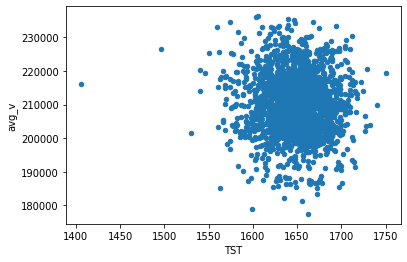

In [12]:
df = pd.merge(df_target, df_gas, on="NPLV", how="left")
df.plot.scatter('TST', 'avg_v')

In [13]:
df[df.columns.str.contains("avg_")]

ValueError: Item wrong length 35 instead of 2063.